# Setup Freyberg pilot points to use regularization and see what happens...

### With our first attempt at pilot points, we saw bad things.  So lets see if we can fix the problem by using regularization.

Recall from Anderson et al. (2015) regularization adds an additional term to our total objective function:

<img src="tik-reg_eq9.9.png" style="float: center">

The first term to the right of the equals sign is the measurement objective function from
Eqn (9.6), which is calculated as the sum of squared weighted residuals, where *n* residuals,
*ri*, are calculated from hard knowledge and wi are their respective weights. The second
term quantifies the penalty resulting from deviations from soft knowledge as the sum
of *q* deviations from *j* soft knowledge conditions *fj*, where *fj* is a function of model parameters
*p*. 

## A calibrated model, therefore, is found by minimizing both the measurement objective function (hard data) and the soft knowledge penalty.


### Let's see how to do this in PEST


In [2]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

In [3]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/rjhunt1/GW1876-SD18/activities/freyberg_pilot_points_2/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.1, 7/21/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 07/21/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/04/21 17:23:59

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1   

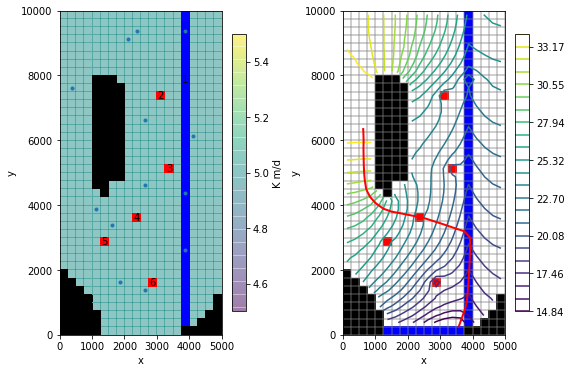

In [7]:
fs.plot_model(working_dir, pst_name)

## Okay, we have a running PEST setup and model to work with - let's use a shortcut variable to tell pyemu that we want interrogate or look at this particular model.... 

In [5]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))

### Now when we have to tell pyemu which model we mean we just type pst


## In the ``intro_to_regularization``, we talked about two common forms of regularization.  Here we will add both types to the control file.  

### First, let's add a few preferred value equations for the recharge and well flux parameters.  First, let's use pyemu to tell us what parameter groups are in our PEST control file:

In [6]:
pst.parameter_data.pargp.unique()

array(['hk', 'porosity', 'rch', 'w0', 'w1'], dtype=object)

### See the pst at the beginning of the line of code?  That is how pyemu knows which model to report on.

### Even more power than echoing out what is in the PEST files, we can use pyemu to add preferred value regularization equations to the recharge and well parameter groups.  Note though, pyemu doesn't call it "preferred value"! Rather, it uses the mathematical term "Zero Order Tikhonov" so we have to use that.

In [11]:
pyemu.helpers.zero_order_tikhonov(pst,par_groups=["rch","w0","w1"])
#pyemu.helpers.zero_order_tikhonov(pst)

### Note that only recharge and well parameters were regularized (i.e., were the only ones listed at the end of the line of code).

##### Let's see how the preferred value equation looks:

In [15]:
pst.prior_information

,equation,obgnme,pilbl,weight
pilbl,,,,
rch_0,1.0 * log(rch_0) = 0.000000E+00,regulrch,rch_0,1.660964
rch_1,1.0 * log(rch_1) = 0.000000E+00,regulrch,rch_1,0.926628
w0_r09_c16,1.0 * log(w0_r09_c16) = 0.000000E+00,regulw0,w0_r09_c16,1.660964
w0_r11_c13,1.0 * log(w0_r11_c13) = 0.000000E+00,regulw0,w0_r11_c13,1.660964
w0_r20_c14,1.0 * log(w0_r20_c14) = 0.000000E+00,regulw0,w0_r20_c14,1.660964
w0_r26_c10,1.0 * log(w0_r26_c10) = 0.000000E+00,regulw0,w0_r26_c10,1.660964
w0_r29_c06,1.0 * log(w0_r29_c06) = 0.000000E+00,regulw0,w0_r29_c06,1.660964
w0_r34_c12,1.0 * log(w0_r34_c12) = 0.000000E+00,regulw0,w0_r34_c12,1.660964
w1_r09_c16,1.0 * log(w1_r09_c16) = 0.000000E+00,regulw1,w1_r09_c16,0.500000


## RECALL:  This report does not mean that the PEST control file has been updated! It is simply reporting what is in pyemu's memory block.


### Now, let's add preferred difference regularization to the spatially distributed parameters.  Note that preferred value only needed one parameter (the value of that parameter).  A preferred difference regularization constraint involves 2 parameters.  But the spatial distance between any two parameters is not the same - how do we deal?  With  geostatistics! 

In [17]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0)
df_pp = pyemu.gw_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
cov = gs.covariance_matrix(df_pp.x,df_pp.y,df_pp.parnme)
pyemu.helpers.first_order_pearson_tikhonov(pst,cov,reset=False,abs_drop_tol=0.1)
pst.prior_information

/Users/rjhunt1/GitHub/pyemu/pyemu/utils/gw_utils.py:256: UserWarning: pp_tpl_to_dataframe has moved to pp_utils
  warnings.warn("pp_tpl_to_dataframe has moved to pp_utils")


,equation,obgnme,pilbl,weight
pilbl,,,,
rch_0,1.0 * log(rch_0) = 0.000000E+00,regulrch,rch_0,1.660964
rch_1,1.0 * log(rch_1) = 0.000000E+00,regulrch,rch_1,0.926628
w0_r09_c16,1.0 * log(w0_r09_c16) = 0.000000E+00,regulw0,w0_r09_c16,1.660964
w0_r11_c13,1.0 * log(w0_r11_c13) = 0.000000E+00,regulw0,w0_r11_c13,1.660964
w0_r20_c14,1.0 * log(w0_r20_c14) = 0.000000E+00,regulw0,w0_r20_c14,1.660964
w0_r26_c10,1.0 * log(w0_r26_c10) = 0.000000E+00,regulw0,w0_r26_c10,1.660964
w0_r29_c06,1.0 * log(w0_r29_c06) = 0.000000E+00,regulw0,w0_r29_c06,1.660964
w0_r34_c12,1.0 * log(w0_r34_c12) = 0.000000E+00,regulw0,w0_r34_c12,1.660964
w1_r09_c16,1.0 * log(w1_r09_c16) = 0.000000E+00,regulw1,w1_r09_c16,0.500000


### Note that the preferred difference = 0, which means our preferred difference regularization is really a preferred *homogeneity* condition!



### Okay, getting close.  Some housekeeping - we need to change PEST's estimation mode from "estimation" to "regularization".  

In [1]:
pst.control_data.pestmode = "regularization"

NameError: name 'pst' is not defined

## And, most importantly we need to see what pyemu has for the all important regularization BIG KNOB, the target objective function - or ``phimlim``.  This is THE ONE INPUT that tells PEST how regularization is enforced.  So let's see what pyemu has for ``phimlim``.  

In [22]:

pst.reg_data.phimlim

'1.0e-10'

### That's no good - way too low - just a "placeholder" value.  Theoritically, it should be the number of non-zero weighted obs, but we saw in the unregularized pilot point run, are best ``phi`` was about 120, so let's try 150 (just a guess)

In [23]:
pst.reg_data.phimlim = 220
pst.reg_data.phimaccept = 240
#pst.svd_data.maxsing = 3

### Now we're ready to write all the information that pyemu has in memory to the PEST control file....

In [25]:
pst.write(os.path.join(working_dir,pst_name))

### You can look at the file we just wrote by opening freyberg_pp.pst in the freyberg_pp directory, but here we'll plunge on.  Let's run it - this will again take a little time, watch the run in the terminal window that launched the notebook....

In [27]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir='.')
os.chdir("..")

## Okay - let's look at how we did

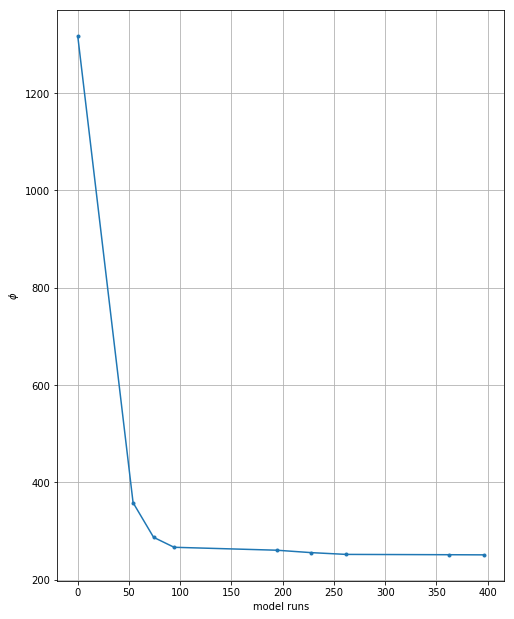

In [31]:
pst.plot(kind="phi_progress")

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

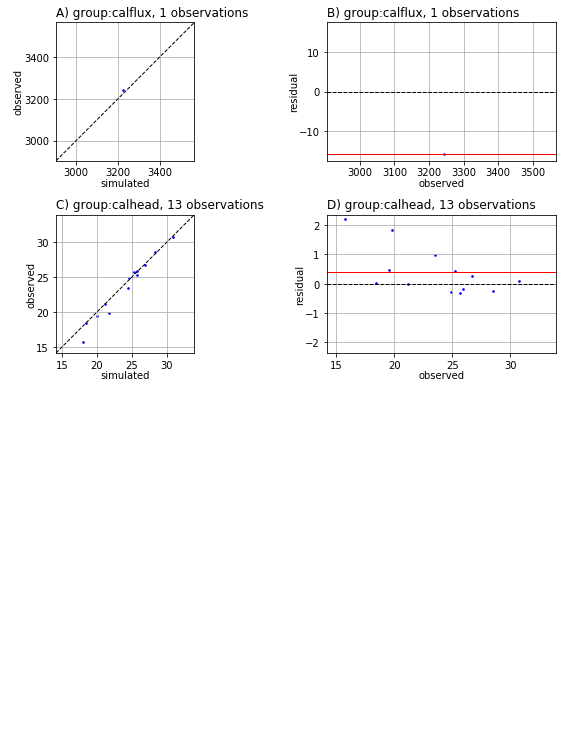

In [32]:
pst.plot(kind="1to1")

### Let's see how the parameter values look.  First, let's take the optimal parameter values from our run and put them through fac2real to make arrays....

In [33]:
os.chdir(working_dir)
pst.parrep(pst_name.replace(".pst",".parb"))
pst.write_input_files()
pyemu.geostats.fac2real("hkpp.dat",factors_file="hkpp.dat.fac",out_file="hk_layer_1.ref")
os.chdir("..")

hk_layer_1.ref 0.5 0.5 -1e+30


/Users/rjhunt1/GitHub/pyemu/pyemu/utils/gw_utils.py:283: UserWarning: fac2real has moved to geostats
  warnings.warn("fac2real has moved to geostats")


## Now let's plot it

/Users/rjhunt1/GitHub/pyemu/pyemu/utils/helpers.py:3255: UserWarning: pyemu.helpers.plot_summary_distributions() has moved to plot_utils
  warnings.warn("pyemu.helpers.plot_summary_distributions() has moved to plot_utils")


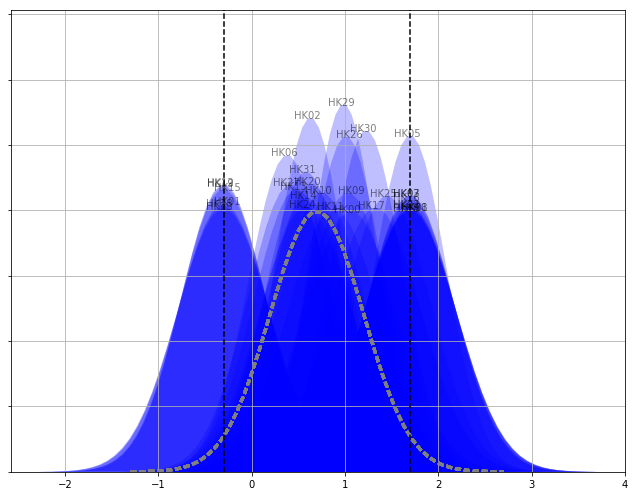

In [39]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)

hk_pars = [p.upper() for p in pst.par_names if p.startswith("hk")]
df_hk = df_paru.loc[hk_pars,:]
ax = pyemu.plot_utils.plot_summary_distributions(df_hk,label_post=True)
mn = np.log10(pst.parameter_data.loc[hk_pars[0].lower(),"parlbnd"])
mx = np.log10(pst.parameter_data.loc[hk_pars[0].lower(),"parubnd"])
ax.plot([mn,mn],ax.get_ylim(),"k--")
ax.plot([mx,mx],ax.get_ylim(),"k--")

### Not a good sign...lots of parameters are still at their bounds...not as many, but still a lot of them.  Let's see what the optimal field look likes....

/Users/rjhunt1/GitHub/pyemu/pyemu/utils/gw_utils.py:256: UserWarning: pp_tpl_to_dataframe has moved to pp_utils
  warnings.warn("pp_tpl_to_dataframe has moved to pp_utils")


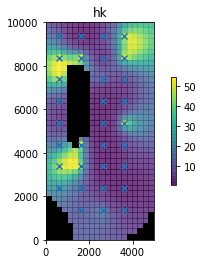

In [42]:
df_pp = pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')

###  Hmm, let's plot the true field again

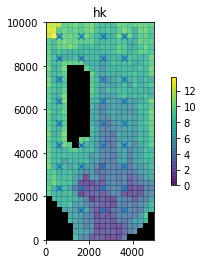

In [43]:
m.upw.hk[0] = os.path.join(fs.BASE_MODEL_DIR,"hk.truth.ref")
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')

## Oh no!!!!!  Better but we are still over fit...so let's back off the fit using ``phimilim``.  But first, just for fun, let's look at the forecast uncertainty

/Users/rjhunt1/GitHub/pyemu/pyemu/utils/helpers.py:3255: UserWarning: pyemu.helpers.plot_summary_distributions() has moved to plot_utils
  warnings.warn("pyemu.helpers.plot_summary_distributions() has moved to plot_utils")


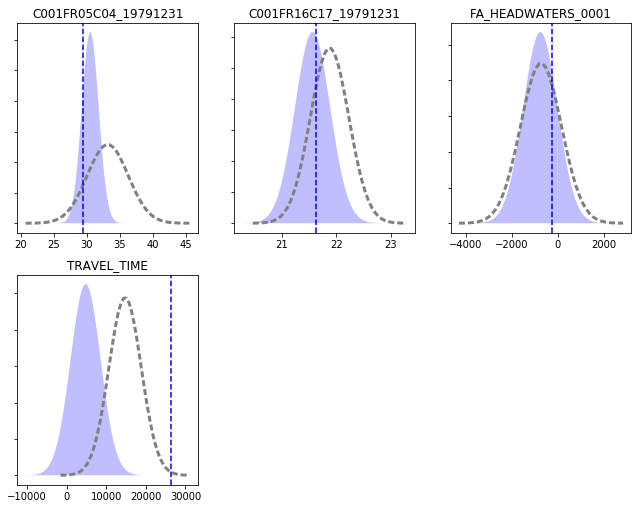

In [44]:
df_foreu = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
figs, axes = pyemu.plot_utils.plot_summary_distributions(df_foreu,subplots=True)
for ax in axes:
    fname = ax.get_title().lower()
    ylim = ax.get_ylim()
    v = pst.observation_data.loc[fname,"obsval"]
    ax.plot([v,v],ylim,"b--")
    ax.set_ylim(ylim)

## We are crushing the posterior uncertainty - the shaded area is thinner and higher than the grey dashed prior uncertainty for several forecasts. But, compared to the "truth" (vertical blue line), we are not doing well - the model is not reliable for all forecasts

# Adjust ``phimlim`` and rerun..

### Let's adjust the weights and ``phimlim`` based on how well we fit last time...and see if we can eliminate our overfitting problem.  How will we know we have eliminated it? In the real world, we will never know...

### So we said wanted our target objective function to be 250.  Where did it end up?  

In [47]:
pst.phi

251.23208218057275

## Pretty much where we should be, but overfit. What does a Phi of 250 look like for the observations? 

In [48]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.res.loc[pst.nnz_obs_names]

,name,group,measured,modelled,residual,weight
name,,,,,,
c001cr03c10_19700102,c001cr03c10_19700102,calhead,26.661526,26.917068,-0.255542,5.00
c001cr03c16_19700102,c001cr03c16_19700102,calhead,23.460564,24.430777,-0.970213,5.00
c001cr04c09_19700102,c001cr04c09_19700102,calhead,28.513522,28.278420,0.235102,5.00
c001cr10c02_19700102,c001cr10c02_19700102,calhead,30.741689,30.824017,-0.082328,5.00
c001cr14c11_19700102,c001cr14c11_19700102,calhead,25.871208,25.704777,0.166431,5.00
c001cr16c17_19700102,c001cr16c17_19700102,calhead,19.817240,21.665195,-1.847955,5.00
c001cr22c11_19700102,c001cr22c11_19700102,calhead,24.858561,24.590744,0.267817,5.00
c001cr23c16_19700102,c001cr23c16_19700102,calhead,19.509003,19.980593,-0.471590,5.00
c001cr25c05_19700102,c001cr25c05_19700102,calhead,25.251713,25.674356,-0.422643,5.00


## Okay, let's use pyemu to change PHIMLIM, let's double it to 500.  And the last line writes the new PEST control file. 

In [51]:
pst.reg_data.phimlim = 500.0
pst.reg_data.phimaccept = 550.0
pst.reg_data.fracphim = 0.75
pst.svd_data.maxsing = 3
pst.write(os.path.join(working_dir,pst_name))

##  You can look at the bottom of freyberg_pp.pst to see the change we made, but let's start the run....

In [52]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir='.')
os.chdir("..")

## Let's look at Phi

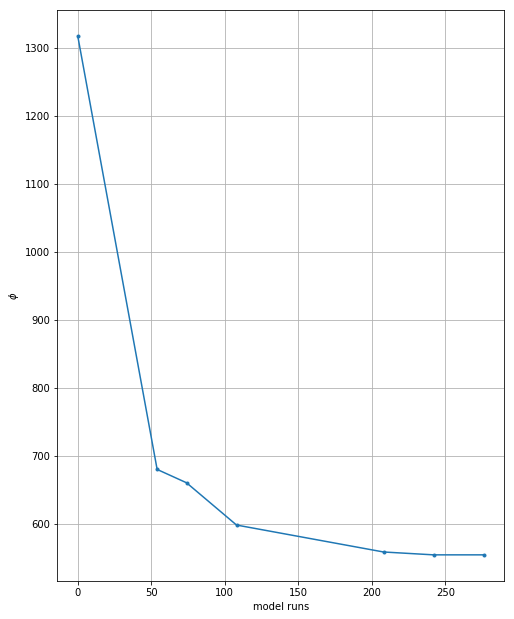

In [57]:
pst.plot(kind="phi_progress")

In [58]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.phi

554.2661293082784

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

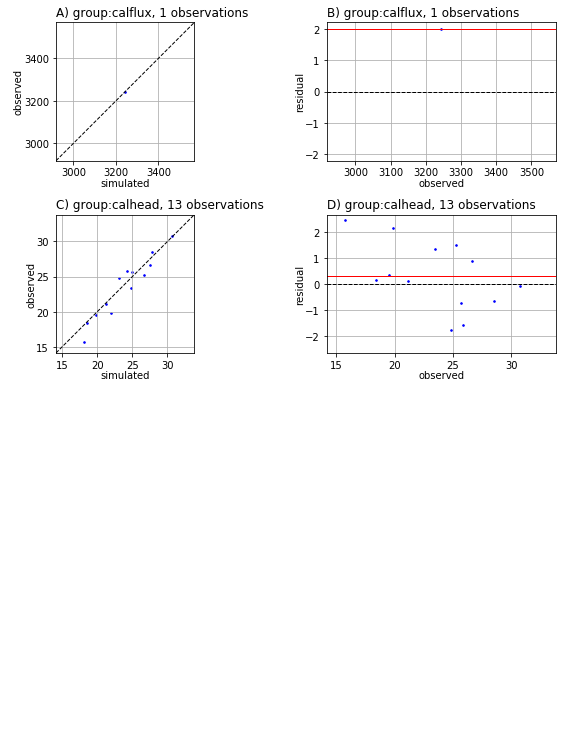

In [56]:
pst.plot(kind="1to1")

## Let's look at the K field again

In [59]:
os.chdir(working_dir)
pst.parrep(pst_name.replace(".pst",".parb"))
pst.write_input_files()
pyemu.geostats.fac2real("hkpp.dat",factors_file="hkpp.dat.fac",out_file="hk_layer_1.ref")
os.chdir("..")


hk_layer_1.ref 4.151 4.151 -1e+30


/Users/rjhunt1/GitHub/pyemu/pyemu/utils/gw_utils.py:283: UserWarning: fac2real has moved to geostats
  warnings.warn("fac2real has moved to geostats")


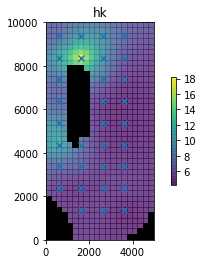

In [60]:
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')

## That's much better...let's compare it to the truth

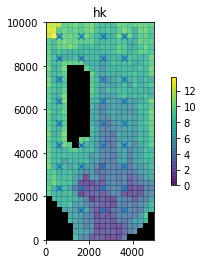

In [62]:
m.upw.hk[0] = os.path.join(fs.BASE_MODEL_DIR,"hk.truth.ref")
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')

## Now let's see how the uncertainty looks...

/Users/rjhunt1/GitHub/pyemu/pyemu/utils/helpers.py:3255: UserWarning: pyemu.helpers.plot_summary_distributions() has moved to plot_utils
  warnings.warn("pyemu.helpers.plot_summary_distributions() has moved to plot_utils")


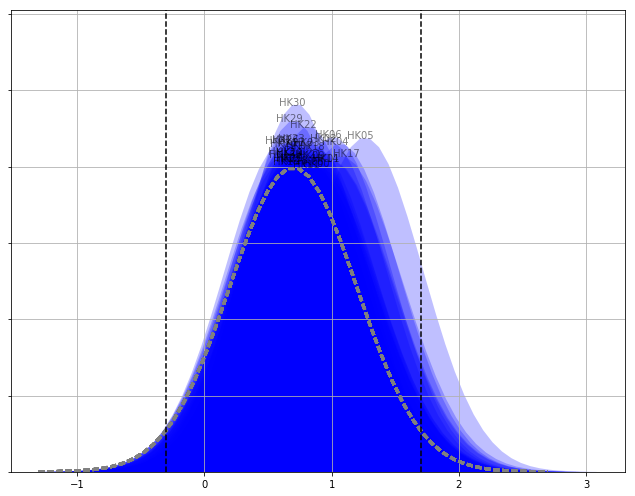

In [67]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
hk_pars = [p.upper() for p in pst.par_names if p.startswith("hk")]
df_hk = df_paru.loc[hk_pars,:]
ax = pyemu.plot_utils.plot_summary_distributions(df_hk,label_post=True)
mn = np.log10(pst.parameter_data.loc[hk_pars[0].lower(),"parlbnd"])
mx = np.log10(pst.parameter_data.loc[hk_pars[0].lower(),"parubnd"])
ax.plot([mn,mn],ax.get_ylim(),"k--")
ax.plot([mx,mx],ax.get_ylim(),"k--")

## Ahhh yeah! Lot fewer pilot points at the bounds.  What about the forecasts?

/Users/rjhunt1/GitHub/pyemu/pyemu/utils/helpers.py:3255: UserWarning: pyemu.helpers.plot_summary_distributions() has moved to plot_utils
  warnings.warn("pyemu.helpers.plot_summary_distributions() has moved to plot_utils")


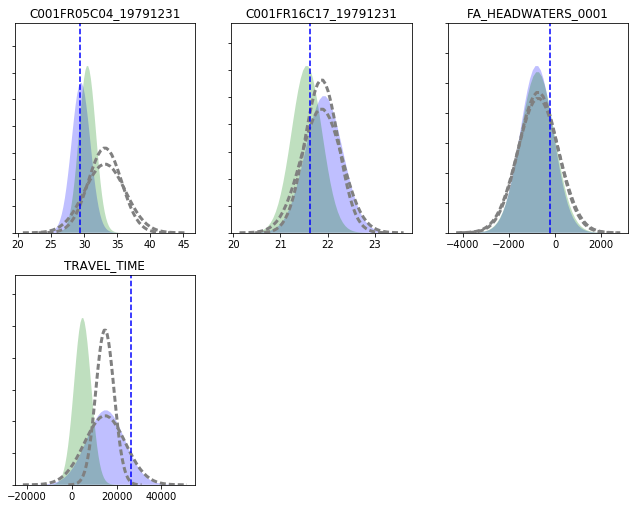

In [66]:
figs, axes = pyemu.helpers.plot_summary_distributions(os.path.join(working_dir,
                    pst_name.replace(".pst",".pred.usum.csv")),subplots=True)
for ax in axes:
    fname = ax.get_title()
    pyemu.helpers.plot_summary_distributions(df_foreu.loc[[fname],:],ax=ax,pt_color='g')
    fname = fname.lower()
    ylim = ax.get_ylim()
    v = pst.observation_data.loc[fname,"obsval"]
    ax.plot([v,v],ylim,"b--")
    ax.set_ylim(ylim)

##  Green shading is the previous run with PHIMLIM = 250; blue shading is the new run with PHIMLIM = 500.  The new run now brackets the "truth" with significant probability for most forecast (FINALLY!!!). So, even though we aren't fitting the observations as well, we are doing much better from a model forecast reliability stand point. 